# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [1]:
# Import essential libraries
from google.colab import drive
import zipfile
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

Load the dataset.

In [2]:
# Load and unzip the dataset

zip_file = '/content/data.zip'

with zipfile.ZipFile(zip_file,'r') as zip_ref:
  zip_ref.extractall("/content")

extracted = "/content"
print("Files in extracted folder:", os.listdir(extracted))


Files in extracted folder: ['.config', 'data.zip', 'data', 'sample_data']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [3]:
# Create a function to load the raw images
image_folder = "/content/data"

def load_img(folder_path):
  image = []
  label =[]

  for sub_fold in os.listdir(image_folder):
        sub_fold_path = os.path.join(image_folder, sub_fold)
        if os.path.isdir(sub_fold_path):
            for file in os.listdir(sub_fold_path):
                file_path = os.path.join(sub_fold_path, file)
                im = cv2.imread(file_path)
                if im is not None:
                    image.append(im)
                    label.append(sub_fold)

  return image, label

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [4]:
# Get the images and their labels

image, label = load_img(image_folder)
print(f"Total images in the folder: {len(image)}")
print(f"Labels: {set(label)}")
counts = {cls: len(os.listdir(os.path.join(image_folder, cls))) for cls in label}
print("Number of images per subfolder: ",counts)

Total images in the folder: 7625
Labels: {'Food_Waste', 'Other', 'Cardboard', 'Metal', 'Glass', 'Paper', 'Plastic'}
Number of images per subfolder:  {'Metal': 1000, 'Food_Waste': 1000, 'Other': 1010, 'Paper': 1030, 'Plastic': 2295, 'Cardboard': 540, 'Glass': 750}


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

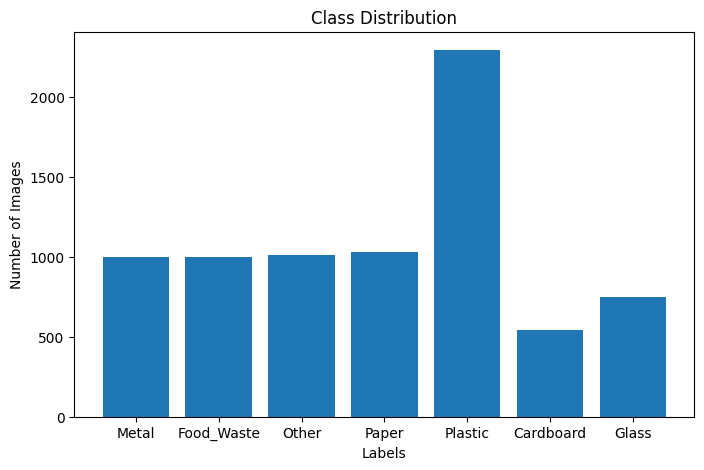

In [5]:
# Visualise Data Distribution
plt.figure(figsize=(8, 5))
plt.bar(counts.keys(), counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

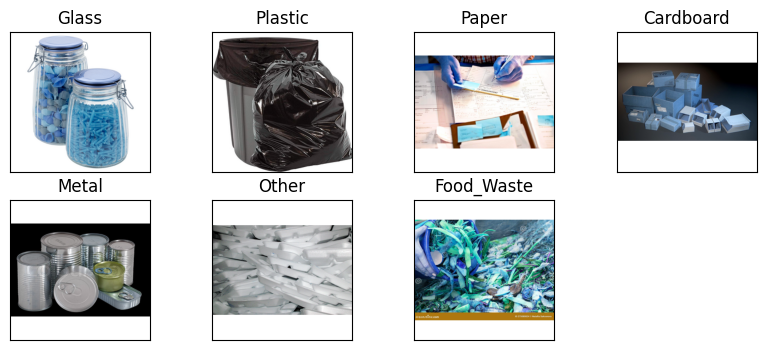

In [6]:
# Visualise Sample Images (across different labels)
label_names = ['Glass', 'Plastic', 'Paper', 'Cardboard', 'Metal', 'Other', 'Food_Waste']
num_classes = 7
fig = plt.figure(figsize=(10, 4))

for i, subfol_name in enumerate(label_names):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    idx = [j for j, lbl in enumerate(label) if lbl == subfol_name]
    img = image[np.random.choice(idx)]
    ax.imshow(img)
    ax.set_title(subfol_name)

plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [7]:
# Find the smallest and largest image dimensions from the data set
min_width = 0
min_height = 0
max_width = 0
max_height = 0

for im in image:
  width, height = im.shape[:2]
  min_width = min(min_width,width)
  min_height = min(min_height,height)
  max_width = max(max_width,width)
  max_height = max(max_height,height)
print(f"Minimum Dimentions: {min_width}x{min_height}")
print(f"Maximum Dimensions: {max_width}x{max_height}")


Minimum Dimentions: 0x0
Maximum Dimensions: 256x256


In [8]:
# Resize the image dimensions
#resized_img = [cv2.resize(im, (224, 224)) for im in image]
resized_images = [cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (128, 128)) for im in image]

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [9]:
# Encode the labels suitably

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label)

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [10]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(resized_images, encoded_labels, test_size=0.3, random_state=42, stratify=encoded_labels)
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])
X_train = X_train / 255.0
X_val = X_val / 255.0

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [11]:
# Build and compile the model
configurations =[
    {'name':'Config 1', 'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.2},
    {'name':'Config 2', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.3},
    {'name':'Config 3', 'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.4},
    {'name': 'Sigmoid CNN', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2),
     'activation': 'sigmoid', 'dropout_rate': 0.3, 'type': 'standard'},
    {'name': 'Tanh CNN', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2),
     'activation': 'tanh', 'dropout_rate': 0.3, 'type': 'standard'},
    {'name':'LeakyReLU CNN', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2),
     'activation': 'leaky_relu', 'dropout_rate': 0.2, 'type': 'leaky'},

    {'name':'Small Kernel CNN', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2),
     'activation': 'relu', 'dropout_rate': 0.3, 'type': 'standard'},

    {'name':'Large Kernel CNN', 'filters': 64, 'kernel_size': (5, 5), 'pool_size': (2, 2),
     'activation': 'relu', 'dropout_rate': 0.3, 'type': 'standard'},

    {'name':'No Dropout CNN', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2),
     'activation': 'relu', 'dropout_rate': 0.0, 'type': 'standard'},
    {'name':'Deep CNN', 'filters': 64, 'depth': 4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.3, 'type': 'deep'},

    {'name':'GlobalAvgPool CNN', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.3, 'type': 'globalavg'},

]
#input_shape = (224, 224, 3)
input_shape = X_train.shape[1:]
def model_build(config, input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(config['filters'], config['kernel_size'], padding='same', input_shape=input_shape))
    model.add(Activation(config['activation']))

    model.add(Conv2D(config['filters'], config['kernel_size']))
    model.add(Activation(config['activation']))

    model.add(MaxPooling2D(pool_size=config['pool_size']))
    model.add(Dropout(config['dropout_rate']))

    model.add(Flatten())
    model.add(Dense(128, activation=config['activation']))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [12]:
# Training

batch_size = 32
num_classes = 7
epochs = 10
input_shape = X_train.shape[1:]

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_dict = {}
model_dict = {}
results = []

for config in configurations:
    print(f"\n Training model with {config['name']}")
    model = model_build(config, input_shape, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop]
    )

    history_dict[config['name']] = history.history
    model_dict[config['name']] = model

    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"{config['name']} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    results.append({
        'Model': config['name'],
        'Test Loss': round(loss, 4),
        'Test Accuracy': round(accuracy, 4)
    })

results_df = pd.DataFrame(results)
print("\n Summary:")
print(results_df.sort_values(by="Test Accuracy", ascending=False))


 Training model with Config 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.2732 - loss: 2.4041 - val_accuracy: 0.3925 - val_loss: 1.5812
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4344 - loss: 1.5081 - val_accuracy: 0.4760 - val_loss: 1.3867
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5751 - loss: 1.1695 - val_accuracy: 0.5271 - val_loss: 1.3287
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6952 - loss: 0.8499 - val_accuracy: 0.5734 - val_loss: 1.2833
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8044 - loss: 0.5779 - val_accuracy: 0.5878 - val_loss: 1.3875
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8457 - loss: 0.4492 - val_accuracy: 0.6119 - val_loss: 1.4093
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9023 - loss: 0.3130 - val_accuracy: 0.5997 - val_loss: 1.4853
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5860 - loss: 1.2564
Config 1 - Test Loss: 1

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

Best Model: LeakyReLU CNN

Evaluating Best Model: LeakyReLU CNN
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

Accuracy: 0.5734
              precision    recall  f1-score   support

       Glass       0.74      0.43      0.54       216
     Plastic       0.57      0.74      0.64       400
       Paper       0.68      0.33      0.45       300
   Cardboard       0.66      0.46      0.54       400
       Metal       0.53      0.38      0.44       404
       Other       0.68      0.40      0.50       412
  Food_Waste       0.52      0.83      0.64       918

    accuracy                           0.57      3050
   macro avg       0.63      0.51      0.54      3050
weighted avg       0.60      0.57      0.56      3050



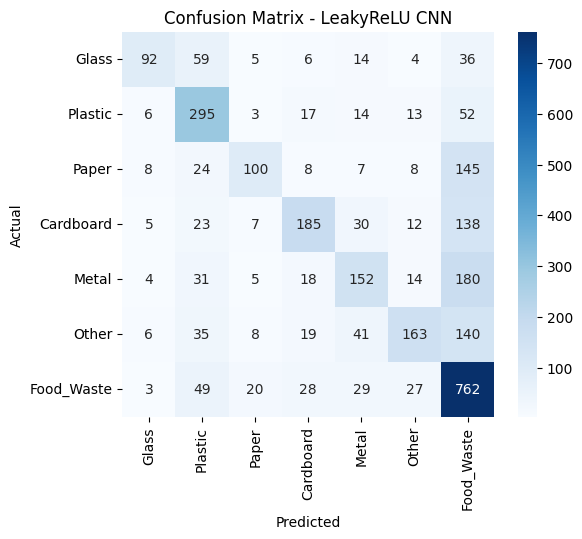

In [13]:
# Evaluate on the test set; display suitable metrics
# Since there is no seperate test data given, splitting the data set again to create test set
X_val, X_test, y_val, y_test = train_test_split(resized_images, encoded_labels, test_size=0.4, random_state=42, stratify=encoded_labels)
X_val = np.array([np.array(img) for img in X_val])
X_test = np.array([np.array(img) for img in X_test])
X_val = X_val / 255.0
X_test = X_test / 255.0



best_config = results_df.sort_values(by="Test Accuracy", ascending=False).iloc[0]['Model']
print(f"Best Model: {best_config}")
best_model = model_dict[best_config]

print(f"\nEvaluating Best Model: {best_config}")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=label_names))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title(f"Confusion Matrix - {best_config}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [14]:
# Define augmentation steps to augment images

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)])

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [26]:
# Create a function to augment the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.3)


In [27]:
# Create the augmented training dataset
train_generator = datagen.flow(X_train, y_train,
    subset='training',
    batch_size=32
)

##### **4.1.2**

Train the model on the new augmented dataset.

In [29]:
# Train the model using augmented images
val_generator = datagen.flow(
    X_train, y_train,
    subset='validation',
    batch_size=32
)
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.2916 - loss: 1.8980 - val_accuracy: 0.2936 - val_loss: 1.8624
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.3136 - loss: 1.8487 - val_accuracy: 0.2936 - val_loss: 1.8586
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.3072 - loss: 1.8396 - val_accuracy: 0.2936 - val_loss: 1.8586
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.3046 - loss: 1.8450 - val_accuracy: 0.2936 - val_loss: 1.8583
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - accuracy: 0.3053 - loss: 1.8496 - val_accuracy: 0.2936 - val_loss: 1.8589
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.3063 - loss: 1.8452 - val_accuracy: 0.2936 - val_loss: 1.8588
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.2958 - loss: 1.8538 - val_accuracy: 0.2936 - val_loss: 1.8588


## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* There are total 7625 images in the folder
* The dataset has 7 subfolders Labeled as Food_Waste, Other, Cardboard, Metal, Glass, Paper and Plastic
* In each subfolder the number of images is different. ('Metal': 1000, 'Food_Waste': 1000, 'Other': 1010, 'Paper': 1030, 'Plastic': 2295, 'Cardboard': 540, 'Glass': 750)
* From the number per subfolder it is clear that there is class imbalance since one has more than 2000 images whereas anothers have less images.
* This class imbalance will affect the performance of the final model because the model simply learns to predict the majority class, it can achieve high accuracy while failing completely on minority classes.
* To overcome this issue we can use augmentation techniques.
* Found the the smallest and largest image dimensions, and resized the images. Initially tried to resize it to 224,224 dimention but while training the model it got crashed. So later changed the size to 128,128.
* Followed by encoding the images suitably.
* The dataset was splitted into train(X_train, y_train) and val (X_val, y_val). train dataset used for training the models and val dataset is used for valuating the model.
* Tried 11 different models. Config 1, Config 2, Config 3, Sigmoid CNN, Tanh CNN, LeakyReLU CN, Small Kernel CNN, Large Kernel CNN, No Dropout CNN, Deep CNN, GlobalAvgPool CNN.
* Using 10 epochs and batch size 32 trained all these models and obtained the accuracy and loss values.
* LeakyReLU CNN gave the best performance with Test loss=1.3277 and Accuracy=0.5774.
* Using this best model, evaluated the model on test dataset. Since no separate test dataset was provided again used the given dataset for the evaluation and got Accuracy = 0.5734.
* Calculated appropriate matrices such as precision,  recall, f1-score and support.
* Tried augmentation steps.

